# Computing Expected Improvement with a Parametric Mean Field Assumption
## What I Need to Do
- [ ] Write a solver for computing the optimal hyperparameters of our model

In [1]:
using Profile
using ProfileView
using Polynomials

All the necessary imports for our computations of interest

In [2]:
include("../bayesian_optimization.jl")
plotlyjs()

WebIO._IJuliaInit()

Plots.PlotlyJSBackend()

## Basic Setup

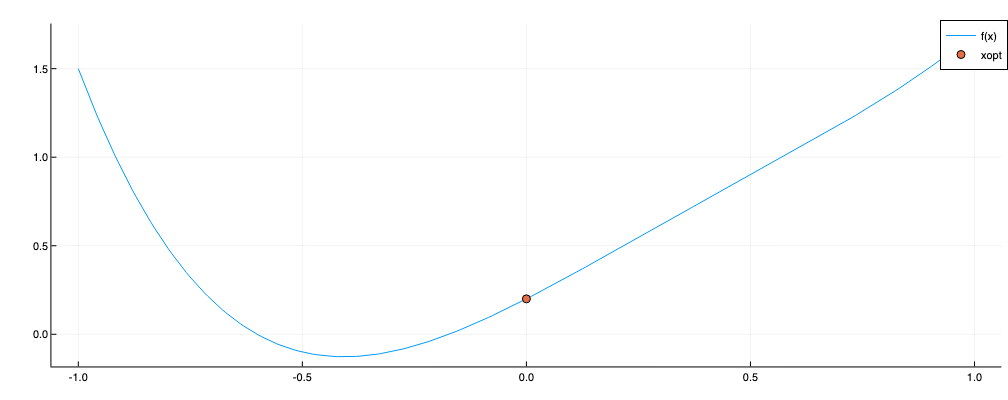

In [3]:
# Visualize 1D test function
# testfn = TestQuadratic1D()
using ForwardDiff

coefficients = [0.8, -1.2, 0.6, 1.3, 0.2]

# Polynomial function
function mypolynomial(x::AbstractVector)
    sum(coefficients[i] * x[1]^(length(coefficients) - i) for i in 1:length(coefficients))
end

# Gradient of the polynomial function
function grad_polynomial(x::AbstractVector)
    ForwardDiff.gradient(mypolynomial, x)[1]  # Computes the gradient
end

# Instantiate the TestFunction
testfn = TestFunction(1, [-1.0 1.0], ([0.0],), mypolynomial, grad_polynomial)

tplot(testfn)

In [4]:
lbs, ubs = get_bounds(testfn)
domain = lbs[1]:.01:ubs[1]

-1.0:0.01:1.0

In [77]:
kernel = Matern32()
polynomial = PolynomialBasisFunction([
        x -> 1., x -> first(x), x -> first(x) ^ 2, x -> first(x)^3, x -> first(x)^4
])
ϵ = 1e-1
Σ = Matrix{Float64}(I(length(polynomial)))
N = 20
observation_noise = 0.
X = randsample(N, testfn.dim, lbs, ubs)
y = testfn(X) + observation_noise * randn(N)

sur_ei = Surrogate(kernel, polynomial, X, y, decision_rule=EI(),
    observation_noise=observation_noise, capacity=N+1, ϵ=ϵ, Σref=Σ)
sur_poi = Surrogate(kernel, polynomial, X, y, decision_rule=POI(),
    observation_noise=observation_noise, capacity=N+1, ϵ=ϵ, Σref=Σ)
sur_lcb = Surrogate(kernel, polynomial, X, y, decision_rule=LCB(),
    observation_noise=observation_noise, capacity=N+1, ϵ=ϵ, Σref=Σ)

Surrogate{RBF = RadialBasisFunction{Float64}}

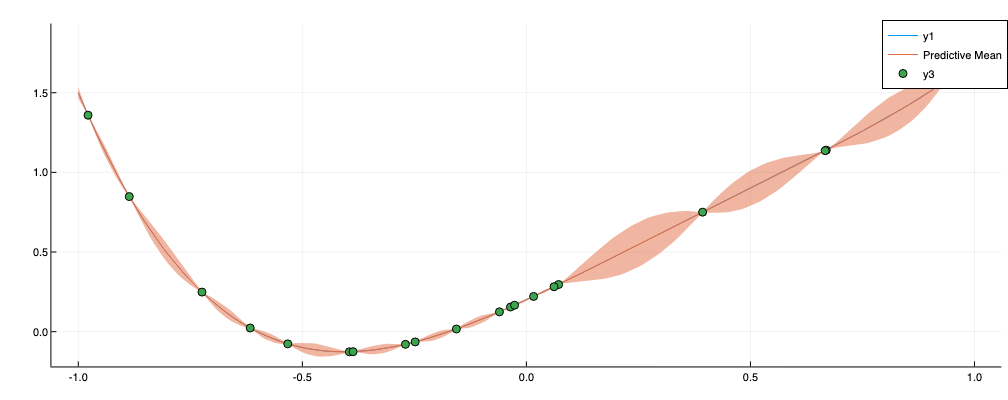

In [78]:
domain = lbs[1]:.01:ubs[1]
μ = similar(domain)
σ = similar(domain)
EIx = similar(domain)
POIx = similar(domain)
LCBx = similar(domain)

for (i, x) in enumerate(domain)
    sx_ei = sur_ei([x], [0.])
    sx_poi = sur_poi([x], [0.])
    sx_lcb = sur_lcb([x], [0.])
    
    μ[i] = sx_ei.μ
    σ[i] = sx_ei.σ
    EIx[i] = eval(sx_ei)
    POIx[i] = eval(sx_poi)
    LCBx[i] = eval(sx_lcb)
end

plot(domain, [testfn([x]) for x in domain])
plot!(domain, μ, ribbons=2σ, label="Predictive Mean")
scatter!(get_active_covariates(sur_ei)', get_active_observations(sur_ei))

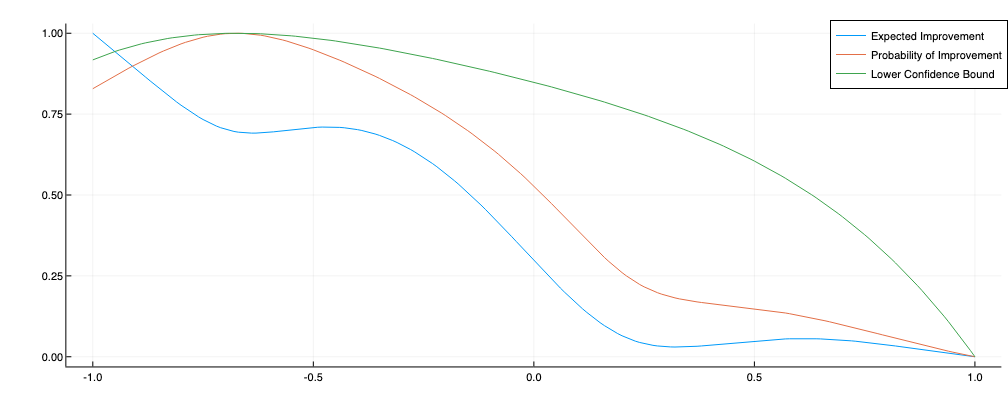

In [67]:
plot(domain, stdize(EIx), label="Expected Improvement")
plot!(domain, stdize(POIx), label="Probability of Improvement")
plot!(domain, stdize(LCBx), label="Lower Confidence Bound")

In [45]:
xnew = [0.]
ynew = testfn(xnew) + observation_noise * randn()
sur = condition!(sur, xnew, ynew)

Surrogate{RBF = RadialBasisFunction{Float64}}

In [51]:
hypers = .1:.01:3.
log_likelihoods = similar(hypers)

for (i, hh) in enumerate(hypers)
    sur = Surrogate(Matern32([hh]), polynomial, X, y,
        decision_rule=EI(),
        observation_noise=observation_noise,
        capacity=N+1,
        ϵ=ϵ,
        Σref=Σ
    )
    log_likelihoods[i] = log_likelihood(sur)
end

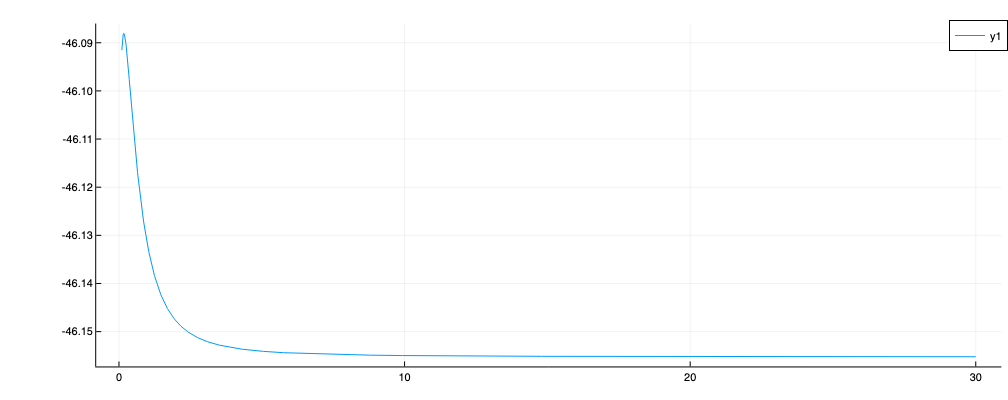

In [50]:
plot(hypers, log_likelihoods)